# Peak detection

Based on this SO answer https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

code for peak detection taken from here: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import quantile_transform

%matplotlib inline

In [2]:
full = pd.read_csv('data/CA1_6_1_clean.csv')

In [3]:
full.head()

,time,0N,1N,2N,3N,4N,5N,6N,7N,8N,...,583N,584N,585N,586N,587N,588N,589N,x,y,segment
0,6,-0.004105,-0.002713,0.002400,-0.002804,0.013982,0.004319,-0.003357,-0.001776,-0.002052,...,0.000585,0.005413,0.009618,0.004061,0.004675,0.001152,-0.000333,-15.463624,2.932973,4.0
1,7,-0.004401,-0.004511,0.001104,-0.002070,0.012163,0.003325,-0.001147,-0.003996,-0.003540,...,-0.000170,0.007227,0.008670,0.006076,0.006172,-0.001081,-0.002290,-16.404171,3.408579,4.0
2,8,-0.003786,-0.005022,0.001733,-0.000330,0.013810,0.003872,-0.003216,-0.002088,-0.003463,...,-0.001343,0.007866,0.008944,0.009129,0.003572,0.000140,-0.003384,-17.335852,3.910841,4.0
3,9,-0.005539,-0.005892,-0.000947,-0.003324,0.012719,0.001616,-0.002414,-0.003358,-0.002223,...,0.000458,0.006610,0.009690,0.007303,0.006286,-0.001653,-0.002121,-18.261171,4.434826,4.0
4,10,-0.004962,-0.007518,0.002856,-0.002459,0.012671,0.004508,-0.002190,-0.003734,-0.000925,...,-0.000420,0.006400,0.007676,0.003326,0.006363,-0.001662,-0.003236,-19.161957,5.008783,4.0


# Why peak detection?

lets look at time-series of cells

In [4]:
def get_angle(coordinates, cx = 0, cy = 0):
    return np.angle((coordinates['x'] - cx) + 1j * (coordinates['y'] - cy))

In [5]:
x_max, y_max = full[['x', 'y']].max()
x_min, y_min = full[['x', 'y']].min()

radius_x = (x_max - x_min) / 2
radius_y = (y_max - y_min) / 2
radius = (radius_x+radius_y)/2

cx1 = x_max - radius
cx2 = x_min + radius
cx = (cx1 + cx2) / 2
cy1 = y_max - radius
cy2 = y_min + radius
cy = (cy1 + cy2) / 2

The only problem is the 180 deg angle => See how the model performs

In [6]:
mi = full.copy()

In [7]:
mi['ang'] = get_angle(mi, cx, cy)


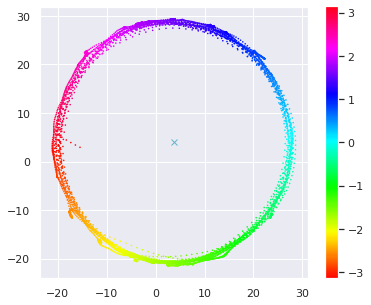

In [8]:
fig, ax = plt.subplots(figsize=(6, 5), ncols=1)
plt.scatter(mi['x'], mi['y'],
        c=mi['ang'],
        cmap='hsv',
        linewidth=0,
        s=2.5)
plt.plot(cx, cy, 'cx') 
plt.colorbar();

In [9]:
mi.drop(['time', 'segment', 'x', 'y'], axis=1, inplace=True)

In [10]:
N_NEURONS = 20

In [11]:
from sklearn.feature_selection import mutual_info_regression

In [12]:
mi_scores = mutual_info_regression(mi.drop(['ang'], axis=1), mi['ang'])

In [13]:
mi_scores_df = pd.DataFrame([mi_scores], columns=mi.drop(['ang'],axis=1).columns).T.rename(columns={0: 'mi_score'})

In [14]:
mi_scores_df = mi_scores_df.sort_values(by=['mi_score'], ascending=False)

In [15]:
best = mi_scores_df.iloc[:N_NEURONS]

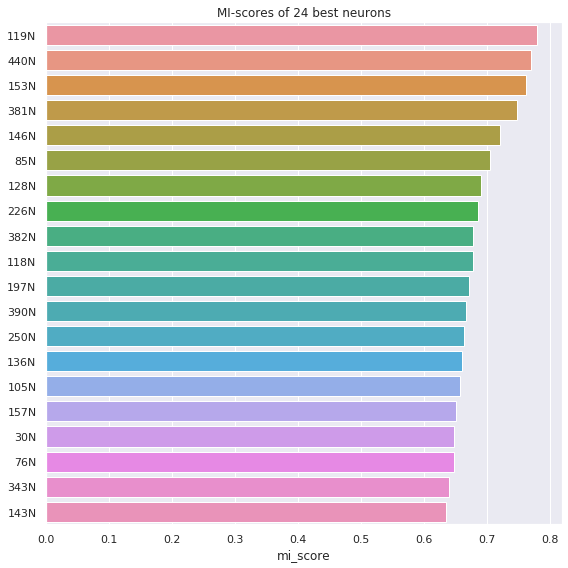

In [16]:
fig, ax = plt.subplots(figsize=(8, 8), ncols=1)

ax = sns.barplot(x=best['mi_score'], y=best.index, ax=ax);
ax.set_title("MI-scores of 24 best neurons");
fig.tight_layout();

In [17]:
worst = mi_scores_df.iloc[-N_NEURONS:].sort_values(by=['mi_score'], ascending=True)

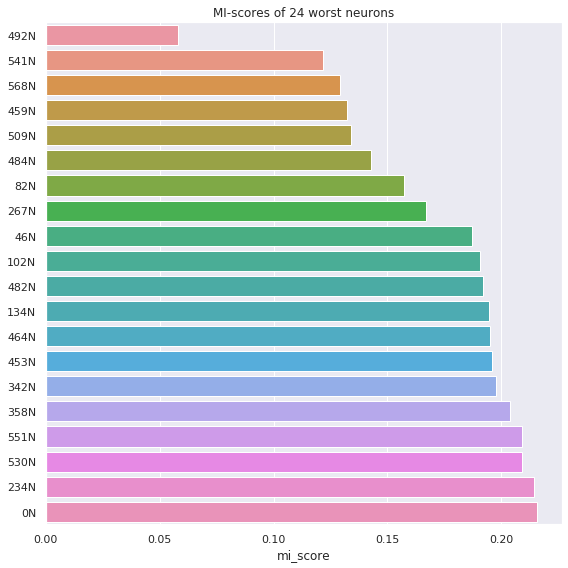

In [18]:
fig, ax = plt.subplots(figsize=(8, 8), ncols=1)

ax = sns.barplot(x=worst['mi_score'], y=worst.index, ax=ax);
ax.set_title("MI-scores of 24 worst neurons");
fig.tight_layout();

In [57]:
neurons = best.index[:10]

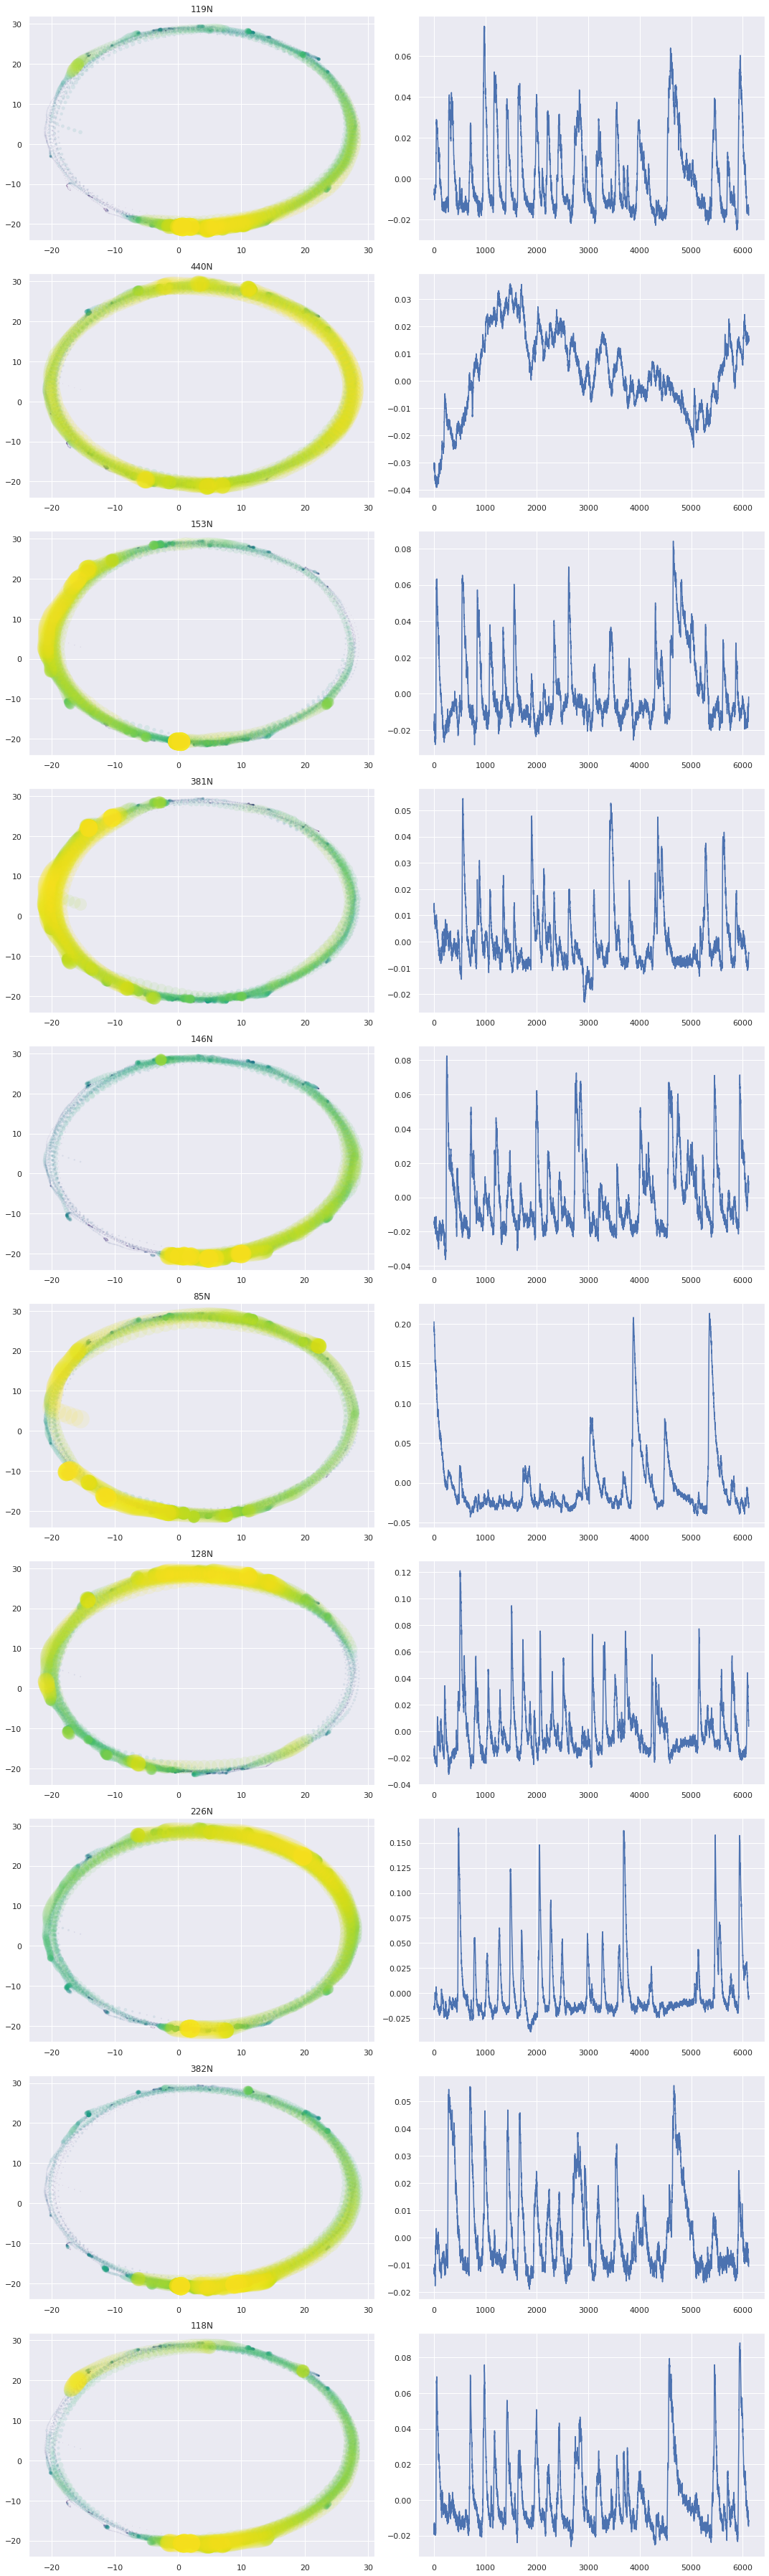

In [58]:
plt.figure(figsize=(15, 50))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/best_mi_time_series.png')

In [41]:
neurons = worst.index[:10]

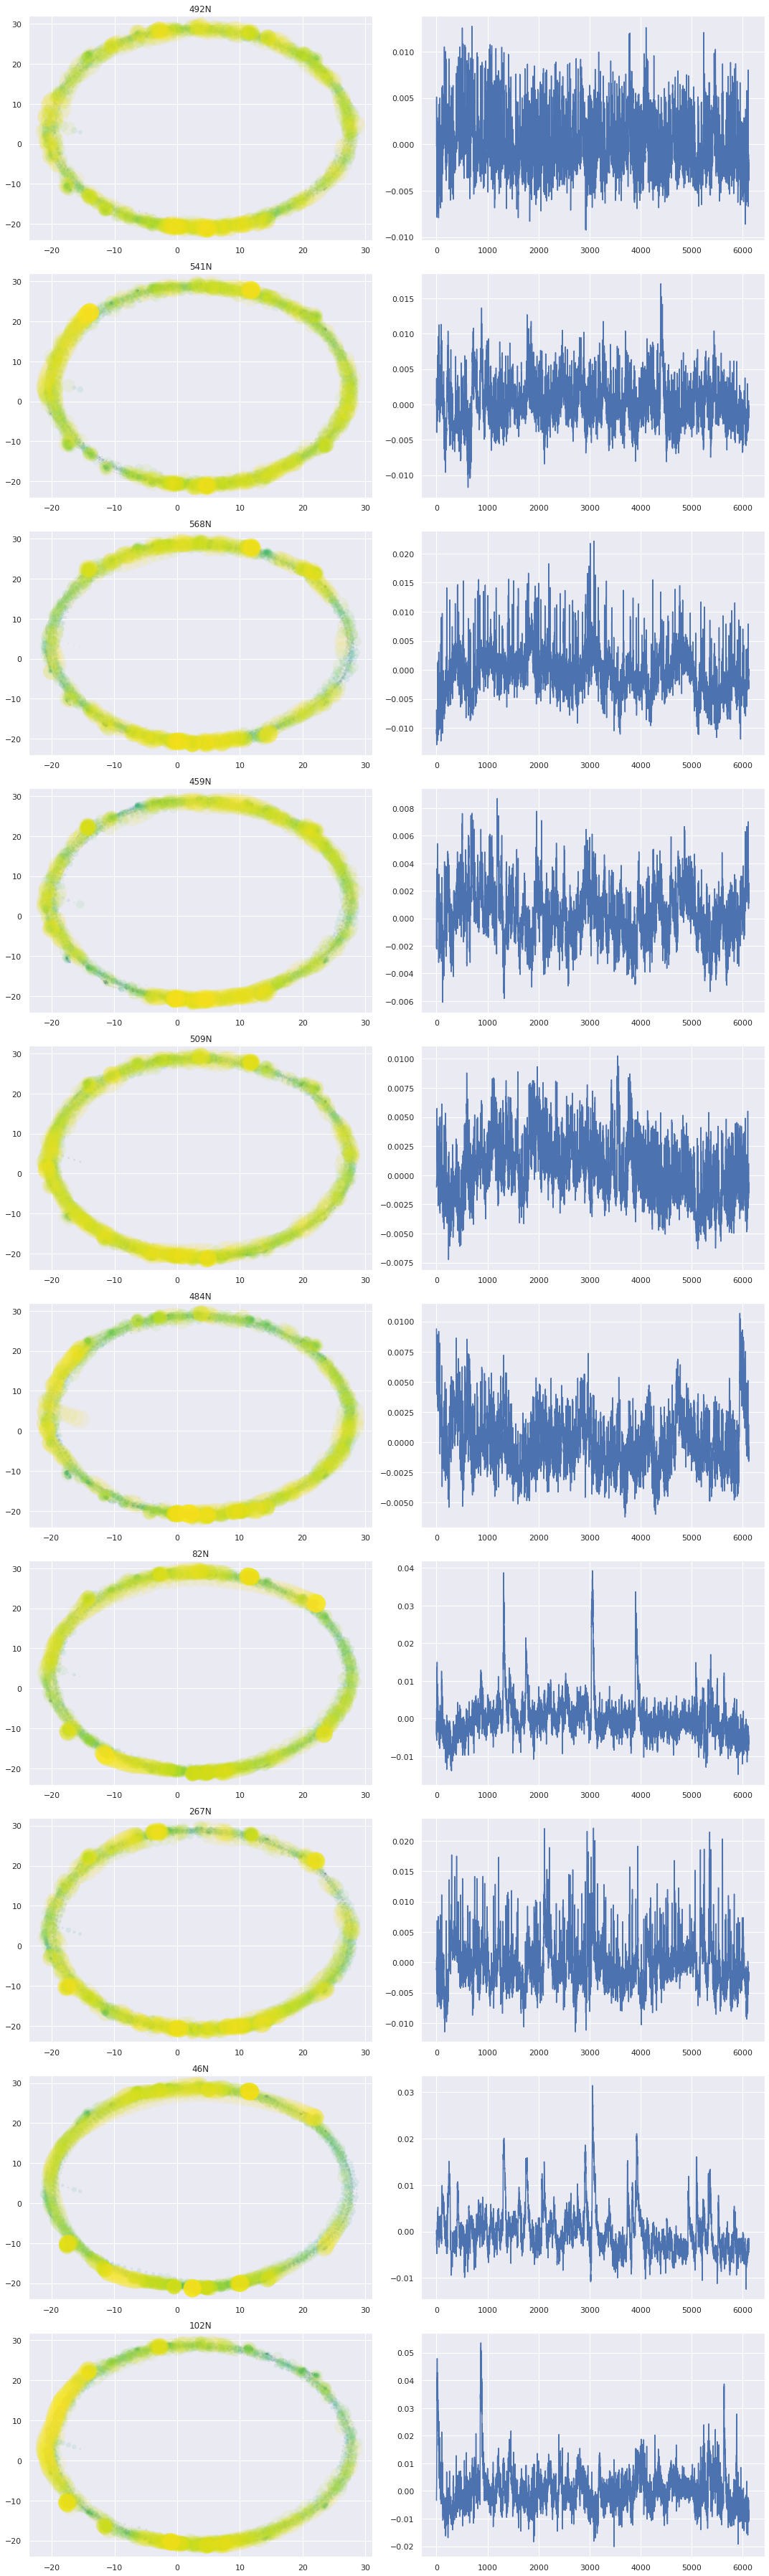

In [42]:
plt.figure(figsize=(15, 50))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/worst_mi_time_series.png')

## Conclusion

use peak detection for place cells.

cell with a relatively high number of peaks most likely is a place cell

# Actual peak detection

In [23]:
from scipy.signal import find_peaks

In [24]:
neurons = full.drop(['time', 'x', 'y', 'segment'],axis=1).columns

In [26]:
n_out = []

In [27]:
stat = full.describe()
for n in neurons:
    peaks = find_peaks(full[n], distance=100)[0]
    mean = stat[n].loc['mean']
    std = stat[n].loc['std']
    upper = mean + std * 1
    coord = []
    for p in peaks:
        r = full.iloc[p]
        if (r[n] > upper):
            coord.append((p, r[n]))
    n_out.append(len(coord))

In [30]:
n_out_s = pd.Series(n_out, index=neurons)

In [53]:
n_out_s = n_out_s[n_out_s > 10]

In [54]:
n_out_s = n_out_s.sort_values()

In [55]:
neurons = n_out_s[:10].index

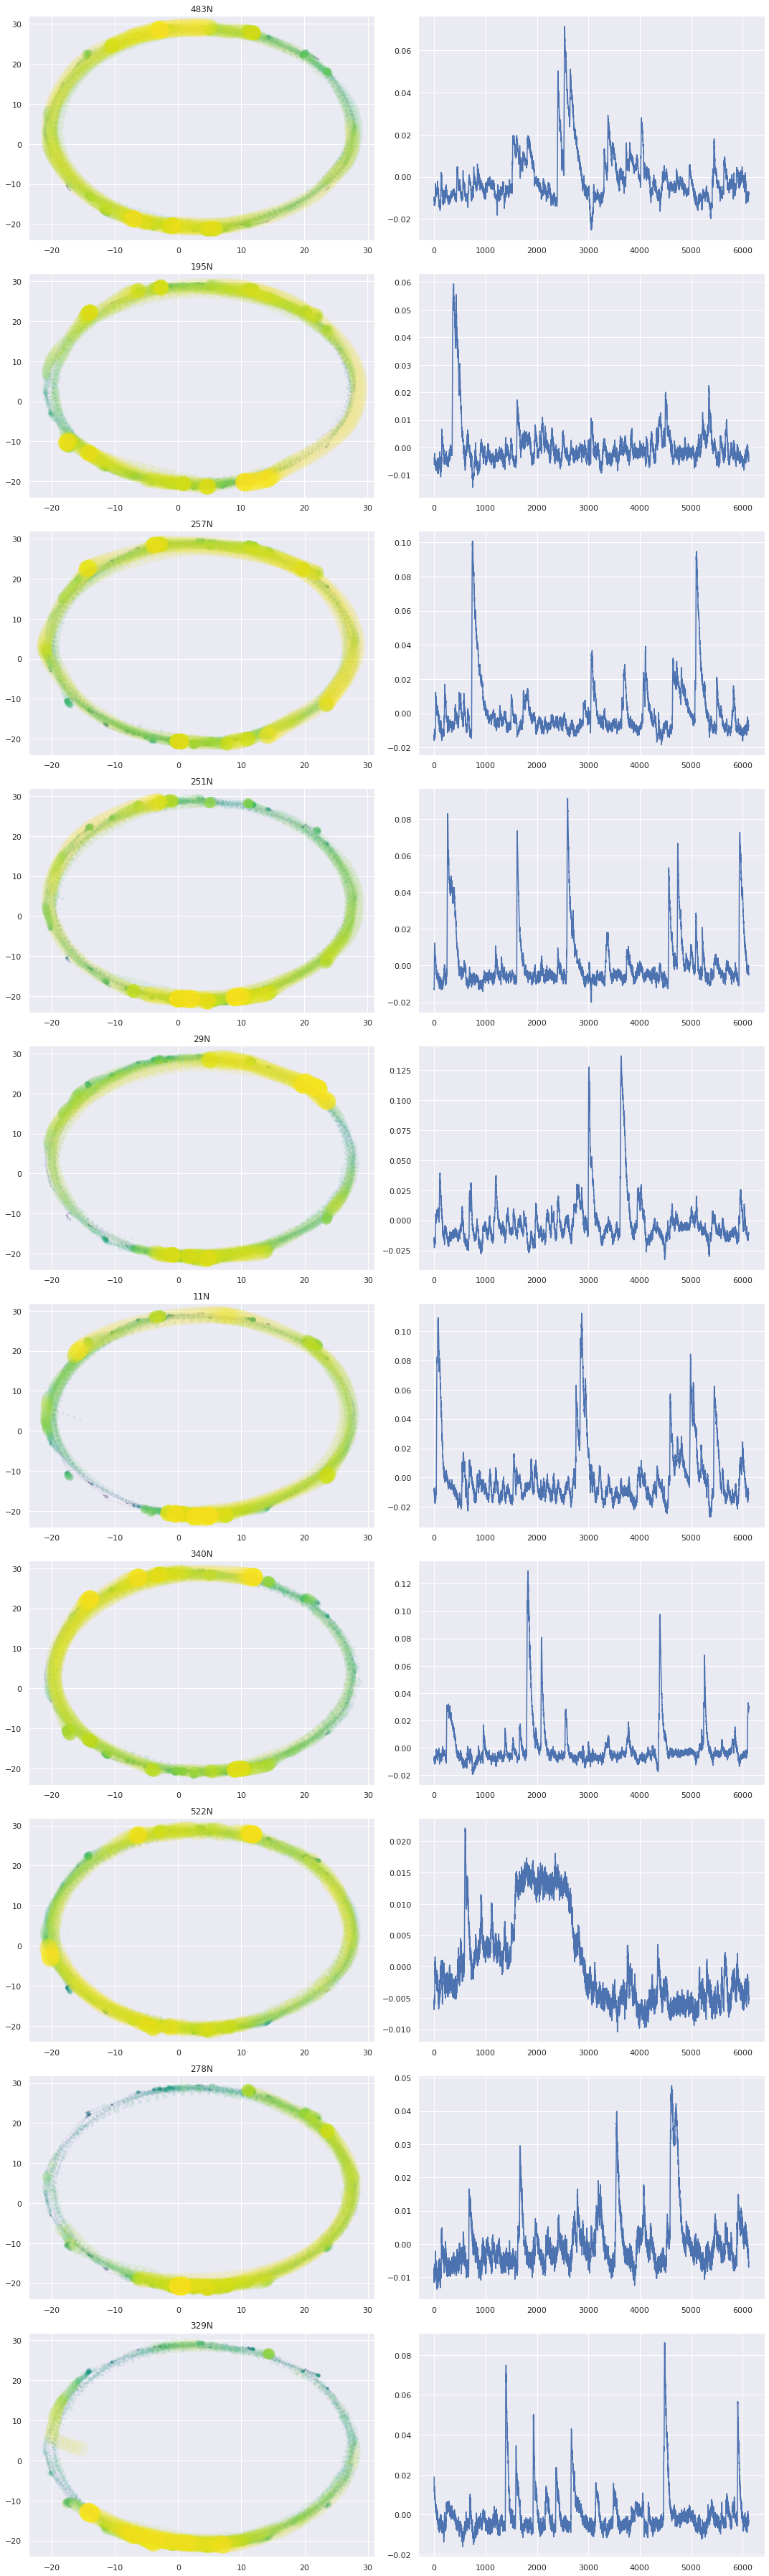

In [56]:
plt.figure(figsize=(15, 50))

N_NEURONS = len(neurons)
for i, n in enumerate(neurons):
    plt.subplot(N_NEURONS, 2, i * 2 + 1)
    plt.title(n)
    s = full.loc[:, ['x', 'y', n]].sort_values(n)
    s[n] = quantile_transform(s[n].values.reshape(-1, 1), copy=True)
    # heatmap
    plt.scatter(s['x'], s['y'],
                c=s[n],
                cmap='viridis',
                linewidth=0,
                s=np.exp(6.5*s[n]),
                alpha=0.1,
                edgecolors='none')
    
    plt.subplot(N_NEURONS, 2, i * 2 + 2)
    plt.plot(full[n])

plt.tight_layout();
plt.savefig('img/best_out_time_series.png')